In [61]:
%matplotlib inline
import numpy as np
import sygma
import matplotlib.pyplot as plt
from galaxy_analysis.plot.plot_styles import *
import galaxy_analysis.utilities.convert_abundances as ca

from gizmo_analysis import gizmo_star

from gizmo_analysis.gizmo_agetracers import FIRE2_yields
from utilities.basic import constant 

from scipy import integrate


def plot_settings():
    fsize = 21
    rc('text',usetex=False)
    rc('font',size=fsize)
    return

In [105]:
snIa_yields = {}
snII_yields = {}
wind_yields = {}

elements = ['metals','helium','carbon','nitrogen','oxygen',
                         'neon','magnesium','silicon','sulphur',
                         'calcium','iron']
metals = ['carbon','nitrogen','oxygen',
                         'neon','magnesium','silicon','sulphur',
                         'calcium','iron']


all_z = [0.01,1.0]

colors = {}
for i,z in enumerate(all_z):
    colors[z] = magma((i+1)/(1.0*np.size(all_z)+1))
yield_objs = {}

for z in all_z:
    star_massfraction = {}
    for e in elements:
        star_massfraction[e] = z * gizmo_star.sun_massfraction[e]
    

    
         #  Yields here is a dictionary with element names as kwargs
        # and yields (in Msun) as values
    snIa_yields[z] = gizmo_star.get_nucleosynthetic_yields('supernova.ia',
                                                  star_metallicity=z,
                                                  star_massfraction=star_massfraction,
                                                  normalize=False)

    snII_yields[z] = gizmo_star.get_nucleosynthetic_yields('supernova.ii',
                                              star_metallicity=z,
                                              star_massfraction=star_massfraction,
                                              normalize=False)
        #    wind yields do not have quantized rates. These are mass fraction
        #
    wind_yields[z] = gizmo_star.get_nucleosynthetic_yields('wind',
                                              star_metallicity=z,
                                              star_massfraction=star_massfraction,
                                              normalize=False)

    
    yield_objs[z] = FIRE2_yields(model_Z = z)
    

In [102]:
gizmo_star.get_nucleosynthetic_yields?

In [110]:
plot_settings()
t = np.linspace(0.0, 14.0,100000) # Gyr

def make_plot(plot_type, t, yo, z_to_plot = all_z, outname = None, 
              denom = 'iron'):
    """
    plot_types :  rate      (Msun per Msun of SF per Myr)
                  yield     (Msun per Msun of SF)
                  abundance (cum. abundance ratio using denom as element of denominator)
    """
    
    tmyr = 1.0E3 * t
    
    ylabels = {'rate' : r'Rate [M$_{\odot}$ / (M$_{\odot}$ of SF) / Myr]',
               'yield': r'Yield [M$_{\odot}$ / (M$_{\odot}$ of SF)]',
               'fraction' : r'Cumulative Fraction',
               'abundance' : '[X/' + constant.element_symbol_from_name[denom].capitalize() + ']'}
    
    ylims   = {'rate' : (1.0E-5,1.0),
               'yield': (1.0E-5,0.02),
               'fraction': (0.0,1.0),
               'abundance' : (-2,1)}
        
        

    nrow = 3
    ncol = 3
    
    fig,ax = plt.subplots(nrow,ncol,sharex=True,sharey=True)
    fig.subplots_adjust(wspace=0,hspace=0)
    fig.set_size_inches(ncol*7,nrow*7)
     
    for z in z_to_plot:
        if plot_type == 'abundance':
            denom_yield = integrate.cumtrapz(yo[z].yields(t,denom),t)
                
        axi=0
        axj=0
        for e in metals:
            axindex = (axi,axj)
            
            
    
            if plot_type == 'rate':
                plotx = tmyr
                ploty = yo[z].yields(t,e) / 1.0E3
            elif plot_type == 'yield' or plot_type == 'fraction':
                plotx = 0.5 * (tmyr[1:]+tmyr[:-1])
                ploty = integrate.cumtrapz(yo[z].yields(t,e),t)
                
                if plot_type == 'fraction':
                    ploty = ploty / ploty[-1]
                
            elif plot_type == 'abundance':
                
                plotx = 0.5 * (tmyr[1:]+tmyr[:-1])
                
                num_yield = integrate.cumtrapz(yo[z].yields(t,e),t)
                
                ploty = ca.abundance_ratio_array( constant.element_symbol_from_name[e].capitalize(),
                                                   num_yield,
                                                   constant.element_symbol_from_name[denom].capitalize(),
                                                   denom_yield, 'mass')
                
            
            label = r"Z = %0.2f Z$_{\odot}$"%(z)
            
            ax[axindex].plot(plotx, ploty, lw = 3 , color=colors[z],
                             label=label)
            
            xy = (0.6,0.9)
            ax[axindex].annotate(e, xy,xytext=xy, xycoords = 'axes fraction')
            
            ax[axindex].set_ylim(ylims[plot_type])
            ax[axindex].set_xlim(1.0,1.0E4)
            
            if plot_type == 'rate' or plot_type == 'yield':
                ax[axindex].semilogy()
                
            ax[axindex].semilogx()
            
                
            axj = axj + 1
            if axj >= ncol:
                axj = 0
                axi = axi + 1

    for a in np.arange(nrow):
        ax[(a,0)].set_ylabel(ylabels[plot_type])
        ax[(nrow-1,a)].set_xlabel(r'Time (Myr)')
    
    ax[(nrow-1,ncol-1)].legend(loc='best')
    
    
    
    if not (outname is None):
        fig.savefig(outname)
        
    #plt.show()
        
        
    return
    

In [107]:
constant.element_symbol_from_name['oxygen']

'o'

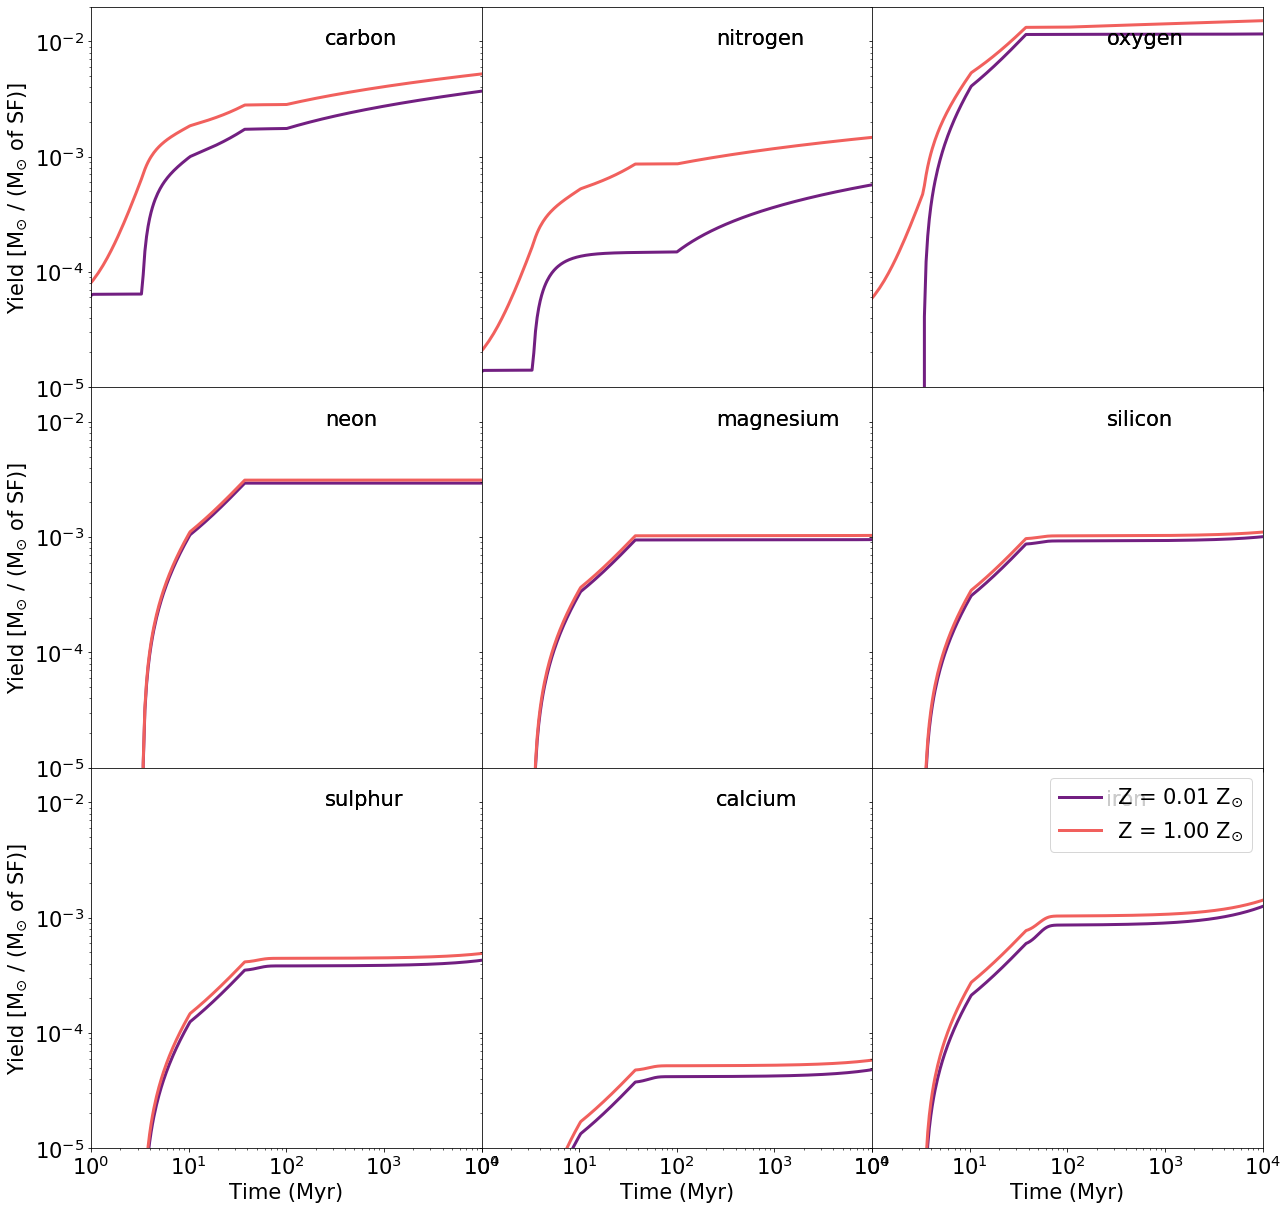

In [112]:
make_plot('yield',t,yield_objs)

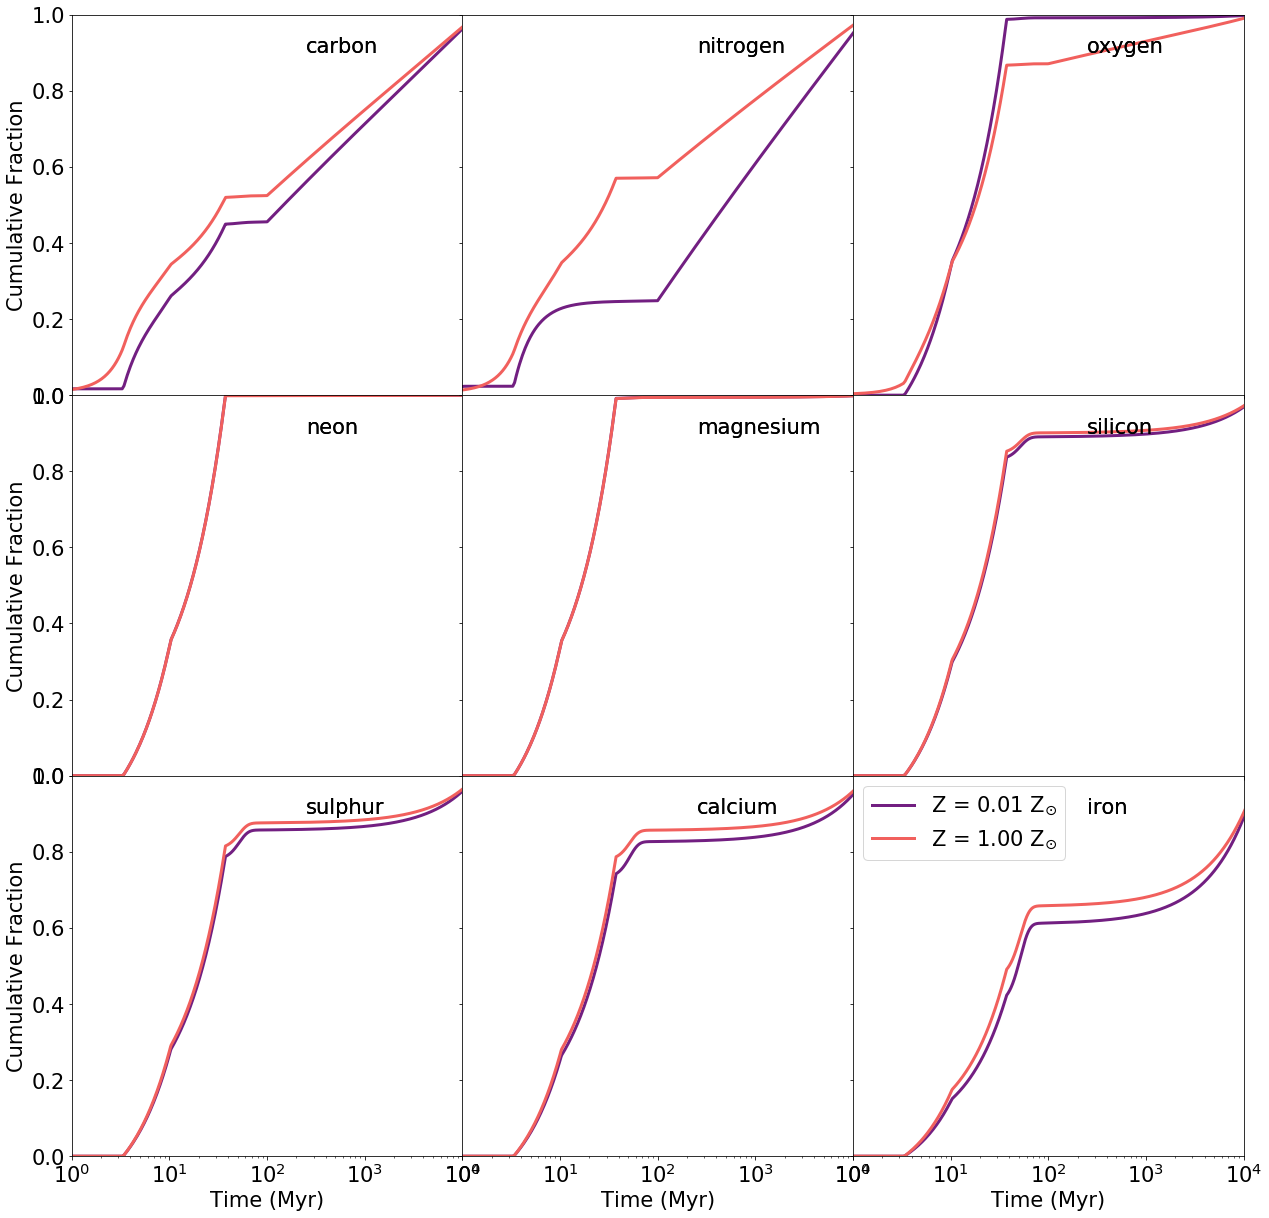

In [114]:
make_plot('fraction',t,yield_objs,outname = "FIRE2-cumulative_yield.png")

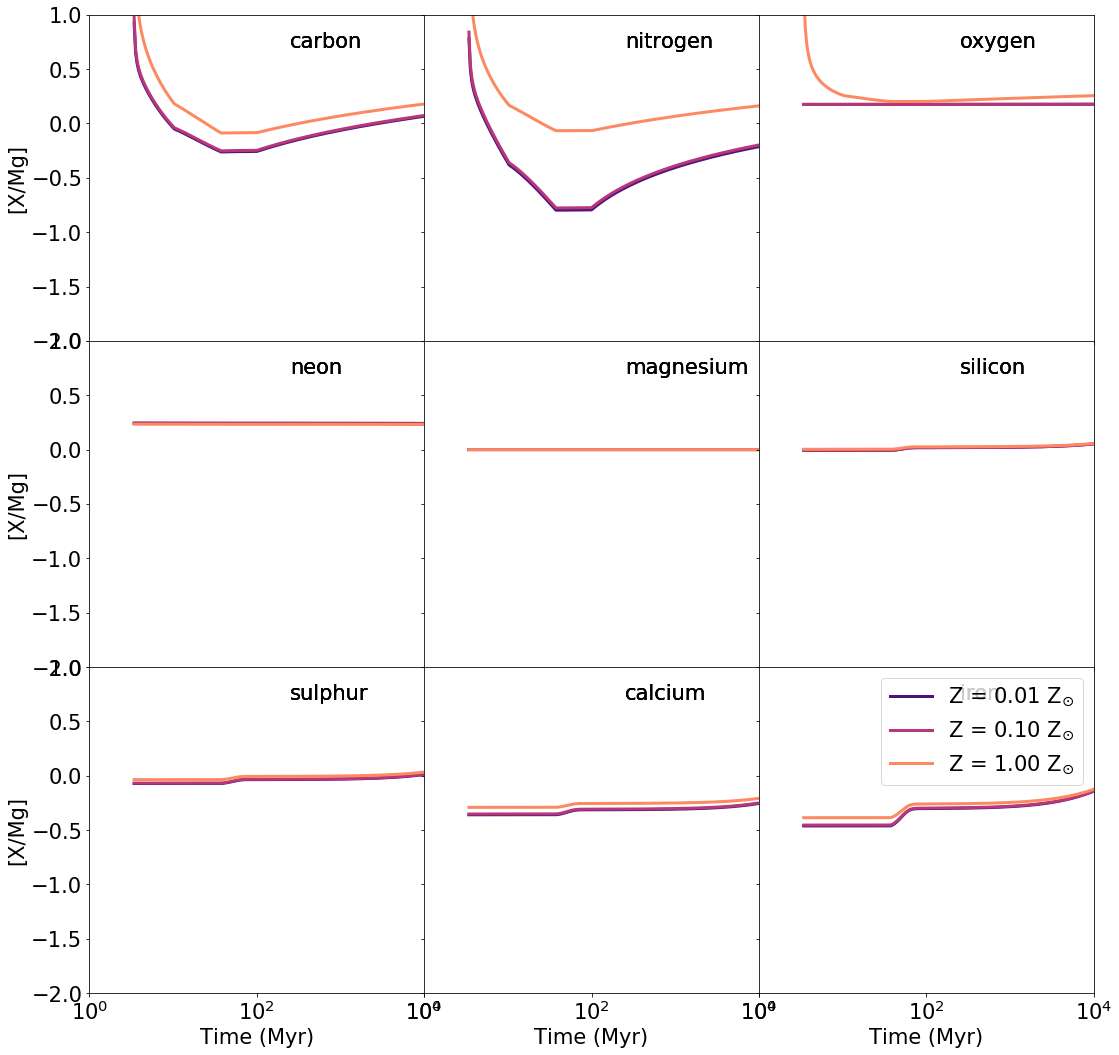

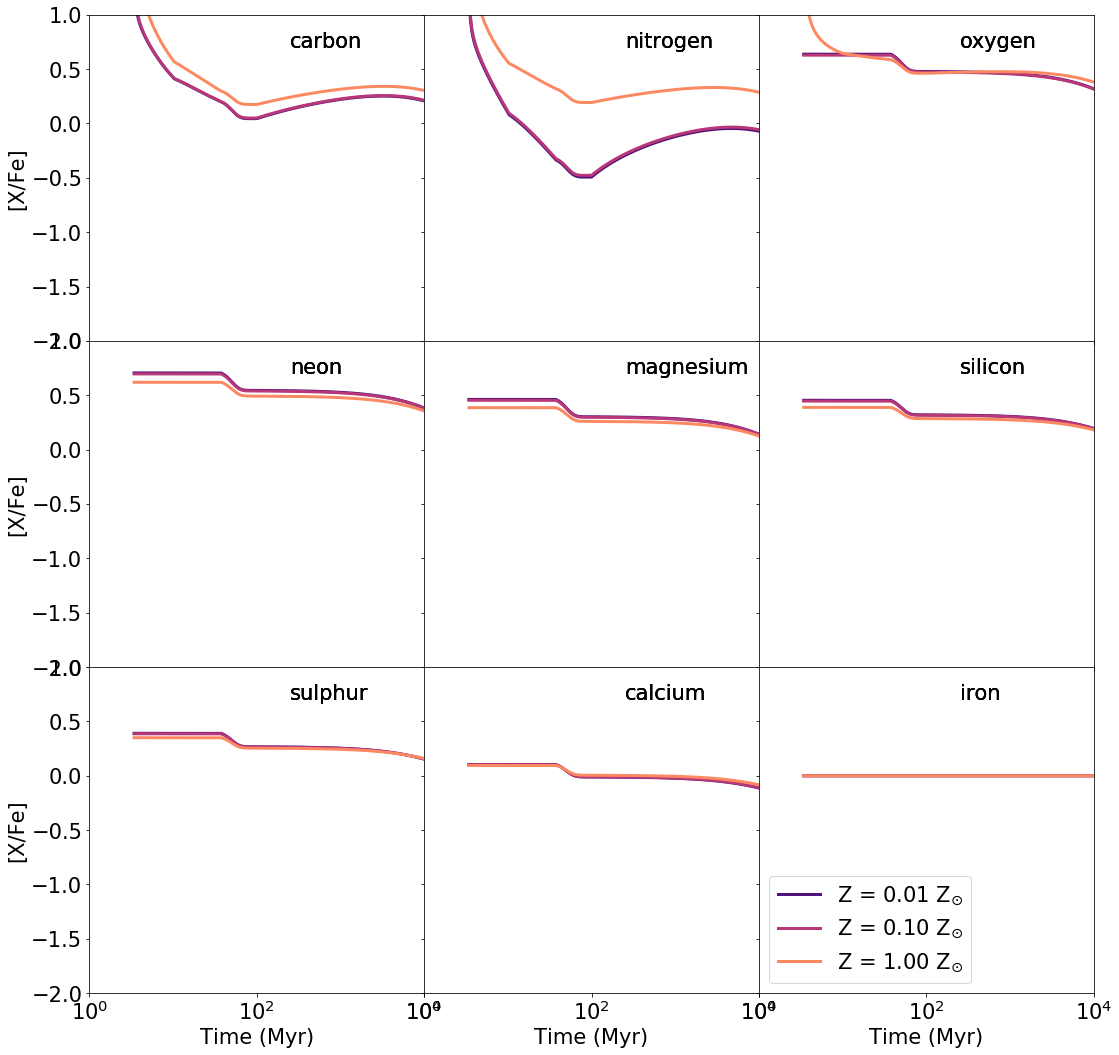

In [97]:
make_plot('abundance',t,yield_objs, denom = 'magnesium')
make_plot('abundance',t,yield_objs, denom = 'iron')

[]

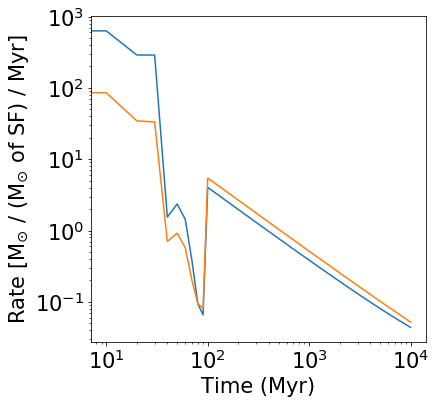

In [21]:
plot_settings()

t = np.linspace(0.0, 10.0,1000) # Gyr
tmyr = 1.0E3 * t

nrow = 1
ncol = 1

fig,ax = plt.subplots()
fig.set_size_inches(ncol*6,nrow*6)

ax.plot(tmyr, yield_objs[1.0].yields(t,'oxygen')*1.0E3)
ax.plot(tmyr, yield_objs[1.0].yields(t,'carbon')*1.0E3)

ax.semilogx()
#ax.semilogy()

ax.set_ylabel(r'Rate [M$_{\odot}$ / (M$_{\odot}$ of SF) / Myr]')
ax.set_xlabel(r'Time (Myr)')
ax.semilogy()

[]

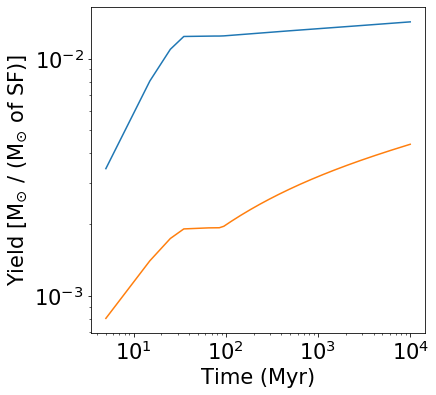

In [29]:
plot_settings()

t = np.linspace(0.0, 10.0,1000) # Gyr
tmyr = 1.0E3 * t

nrow = 1
ncol = 1

fig,ax = plt.subplots()
fig.set_size_inches(ncol*6,nrow*6)

ax.plot(0.5*(tmyr[1:]+tmyr[:-1]), integrate.cumtrapz(yield_objs[1.0].yields(t,'oxygen'),t))
ax.plot(0.5*(tmyr[1:]+tmyr[:-1]), integrate.cumtrapz(yield_objs[1.0].yields(t,'carbon'),t))

ax.semilogx()
#ax.semilogy()

ax.set_ylabel(r'Yield [M$_{\odot}$ / (M$_{\odot}$ of SF)]')
ax.set_xlabel(r'Time (Myr)')
ax.semilogy()

In [27]:
integrate.cumtrapz(yield_objs[1.0].yields(t,'oxygen'), t)

array([0.00343537, 0.00804504, 0.01094072, 0.01239413, 0.01241367,
       0.01243268, 0.01244177, 0.01244411, 0.01244491, 0.01246538,
       0.01250377, 0.01253871, 0.01257076, 0.01260036, 0.01262786,
       0.01265353, 0.01267759, 0.01270024, 0.01272163, 0.01274189,
       0.01276113, 0.01277946, 0.01279695, 0.01281368, 0.0128297 ,
       0.01284508, 0.01285987, 0.0128741 , 0.01288783, 0.01290107,
       0.01291388, 0.01292626, 0.01293826, 0.01294989, 0.01296118,
       0.01297214, 0.0129828 , 0.01299316, 0.01300325, 0.01301308,
       0.01302266, 0.01303201, 0.01304113, 0.01305004, 0.01305875,
       0.01306726, 0.01307558, 0.01308373, 0.0130917 , 0.01309951,
       0.01310717, 0.01311467, 0.01312203, 0.01312924, 0.01313633,
       0.01314328, 0.01315011, 0.01315682, 0.01316341, 0.01316989,
       0.01317626, 0.01318253, 0.01318869, 0.01319476, 0.01320073,
       0.01320661, 0.0132124 , 0.0132181 , 0.01322372, 0.01322926,
       0.01323472, 0.0132401 , 0.0132454 , 0.01325063, 0.01325